# **데이콘 항공편 지연 예측 AI 경진대회 🛫**

- 주제 : 일부 레이블만 주어진 학습 데이터셋을 이용한 항공편 지연 여부 예측
- 설명 : 레이블이 없는 데이터와 함께 항공편 지연 여부를 예측하는 AI 모델 개발
- 최종 성적 : PRIVATE 20위


- [🔗 DACON URL](https://dacon.io/competitions/official/236094/overview/description)

**Dataset Info.**

- train.csv : 1,000,000개의 데이터
- test.csv : 1,000,000개의 데이터
- Features
  - ID : 샘플 고유 id
  - Month: 해당 항공편의 출발 월
  - Day_of_Month: Month에 해당하는 월의 날짜
  - Estimated_Departure_Time: 전산 시스템을 바탕으로 측정된 비행기의 출발 시간 (현지 시각, HH:MM 형식)
  - Estimated_Arrival_Time: 전산 시스템을 바탕으로 측정된 비행기의 도착 시간 (현지 시각, HH:MM 형식)
  - Cancelled: 해당 항공편의 취소 여부 (0: 취소되지 않음, 1: 취소됨)
  - Diverted: 해당 항공편의 경유 여부 (0: 취소되지 않음, 1: 취소됨)
  - Origin_Airport: 해당 항공편 출발 공항의 고유 코드 (IATA 공항 코드)
  - Origin_Airport_ID: 해당 항공편 출발 공항의 고유 ID (US DOT ID)
  - Origin_State: 해당 항공편 출발 공항이 위치한 주의 이름
  - Destination_Airport: 해당 항공편 도착 공항의 고유 코드 (IATA 공항 코드)
  - Destination_Airport_ID: 해당 항공편 도착 공항의 고유 ID (US DOT ID)
  - Destination_State: 해당 항공편 도착 공항이 위치한 주의 이름
  - Distance: 출발 공항과 도착 공항 사이의 거리 (mile 단위)
  - Airline: 해당 항공편을 운항하는 항공사
  - Carrier_Code(IATA): 해당 항공편을 운항하는 항공사의 고유 코드 
  (IATA 공항 코드, 단 다른 항공사가 같은 코드를 보유할 수도 있음)
  Carrier_ID(DOT): 해당 항공편을 운항하는 항공사의 고유 ID (US DOT ID)
  - Tail_Number: 해당 항공편을 운항하는 항공기의 고유 등록번호
  - Delay: 항공편 지연 여부 (Not_Delayed, Delayed)
   - 예측해야 하는 타깃
   - 다수의 데이터에 레이블이 존재하지 않음
  준지도학습을 통해 레이블링 가능




In [1]:
import pandas as pd
import numpy as np
import random
import os
import gc

from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive/dacon')
os.getcwd()

Mounted at /content/gdrive


'/content/gdrive/MyDrive/dacon'

# **📌 pip list**

In [ ]:
pip install pycaret

In [ ]:
pip install  pytorch_tabnet

In [ ]:
!pip install optuna

# **📊 Feature Selection**

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder


In [15]:
train = pd.read_parquet('./train.parquet')

# Origin_State, Destination_State 다른 위치정보와 중복되므로 삭제
train.drop(columns=['Origin_State','Destination_State','Origin_Airport','Destination_Airport'],inplace=True)
#Cancelled, Diverted 제거
train.drop(columns=['Cancelled','Diverted'],inplace=True)
#고유값 삭제
train.drop(columns=['ID'],inplace=True)

#LaeblEncoding
qual_col = ['Tail_Number','Carrier_Code(IATA)','Airline']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
tmp_train=train.dropna().reset_index(drop=True)

X=tmp_train.drop(columns={'Delay'})
y=tmp_train['Delay']

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180475 entries, 0 to 180474
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Month                     180475 non-null  int64  
 1   Day_of_Month              180475 non-null  int64  
 2   Estimated_Departure_Time  180475 non-null  float64
 3   Estimated_Arrival_Time    180475 non-null  float64
 4   Origin_Airport_ID         180475 non-null  int64  
 5   Destination_Airport_ID    180475 non-null  int64  
 6   Distance                  180475 non-null  float64
 7   Airline                   180475 non-null  int64  
 8   Carrier_Code(IATA)        180475 non-null  int64  
 9   Carrier_ID(DOT)           180475 non-null  float64
 10  Tail_Number               180475 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 15.1 MB


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

clf = RandomForestClassifier(n_estimators=100) 
clf.fit(X_train, y_train)

# 테스트데이터셋 결과값 예측 및 정확도 출력
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8215651146039192


In [17]:
feature_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_imp

Tail_Number                 0.149106
Estimated_Arrival_Time      0.136921
Estimated_Departure_Time    0.132387
Distance                    0.117652
Day_of_Month                0.112234
Destination_Airport_ID      0.093870
Origin_Airport_ID           0.091795
Month                       0.068570
Airline                     0.035861
Carrier_ID(DOT)             0.034070
Carrier_Code(IATA)          0.027534
dtype: float64

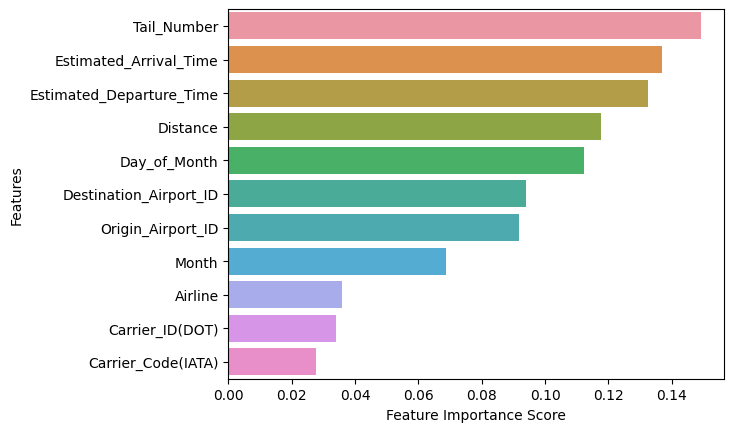

In [18]:
# 변수 중요도 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

# **🔎 Missing values processing**

## **1. Time Prediction Modeling**

- arrival na : 97,352건 → 출발 시간 예측 모델 1
- departure na : 97,331건 → 도착 시간 예측 모델 2
- all na : 11,688건
- notna : 793,629건

In [ ]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
sample_submission = pd.read_csv('data/sample_submission.csv', index_col = 0)

# Origin_State, Destination_State 다른 위치정보와 중복되므로 삭제 #항공기 정보 삭제
train.drop(columns=['Origin_State','Destination_State','Origin_Airport','Destination_Airport','Airline', 'Carrier_Code(IATA)','Carrier_ID(DOT)'],inplace=True)
#Cancelled, Diverted 제거
train.drop(columns=['Cancelled','Diverted'],inplace=True)
#고유값 삭제
train.drop(columns=['ID'],inplace=True)

# Origin_State, Destination_State 다른 위치정보와 중복되므로 삭제 #항공기 정보 삭제
test.drop(columns=['Origin_State','Destination_State','Origin_Airport','Destination_Airport','Airline', 'Carrier_Code(IATA)','Carrier_ID(DOT)'],inplace=True)
#Cancelled, Diverted 제거
test.drop(columns=['Cancelled','Diverted'],inplace=True)
#고유값 삭제
test.drop(columns=['ID'],inplace=True)

train.info()

In [ ]:
train.isnull().sum()

Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Origin_Airport_ID                0
Destination_Airport_ID           0
Distance                         0
Tail_Number                      0
Delay                       744999
dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
#질적 변수들을 수치화합니다
qual_col = ['Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])

In [ ]:
from sklearn.model_selection import train_test_split

time_train=train.drop(columns={'Delay'})
arr_na=time_train[time_train['Estimated_Arrival_Time'].isna() & time_train['Estimated_Departure_Time'].notna()]
dep_na=time_train[time_train['Estimated_Arrival_Time'].notna() & time_train['Estimated_Departure_Time'].isna()]
all_na=time_train[time_train['Estimated_Arrival_Time'].isna() & time_train['Estimated_Departure_Time'].isna()]

X=time_train.dropna()

#arrival na / departure na / all na / all notna
print(len(arr_na),len(dep_na),len(all_na),len(X))

97352 97331 11688 793629


**출발 시간 예측 모델**

In [ ]:
from pycaret.regression import *

reg_test_1 = setup(data=X,
                   target='Estimated_Arrival_Time',
                   train_size= 0.8,
                   fold=5,
                   use_gpu=True)

,Description,Value
0,Session id,2163
1,Target,Estimated_Arrival_Time
2,Target type,Regression
3,Original data shape,"(793629, 8)"
4,Transformed data shape,"(793629, 8)"
5,Transformed train set shape,"(634903, 8)"
6,Transformed test set shape,"(158726, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [ ]:
lgbm=create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,81.9209,36819.7486,191.8847,0.8635,0.5068,1.9485
1,81.4545,37159.3840,192.7677,0.8630,0.5115,1.9800
2,82.7703,38112.9078,195.2253,0.8587,0.5125,1.9777
3,83.0959,38984.9393,197.4460,0.8570,0.5298,2.1832
4,83.7733,39859.4247,199.6483,0.8532,0.5297,2.3186
Mean,82.6030,38187.2809,195.3944,0.8591,0.5181,2.0816
Std,0.8276,1128.2351,2.8827,0.0039,0.0097,0.1451


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tuned_lgbm = tune_model(lgbm,optimize='RMSE')
predict_model(tuned_lgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,56.4077,20362.2881,142.6965,0.9245,0.4313,1.3692
1,56.5372,20730.5136,143.9809,0.9236,0.4350,1.4322
2,55.7685,20581.8284,143.4637,0.9237,0.4321,1.3648
3,55.8138,20696.0610,143.8613,0.9241,0.4442,1.5046
4,55.9936,21250.5919,145.7758,0.9217,0.4527,1.6513
Mean,56.1041,20724.2566,143.9556,0.9235,0.4390,1.4644
Std,0.3127,292.9744,1.0149,0.0010,0.0082,0.1064


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,53.2892,19337.3189,139.0587,0.9288,0.4395,1.4749


,Month,Day_of_Month,Estimated_Departure_Time,Origin_Airport_ID,Destination_Airport_ID,Distance,Tail_Number,Estimated_Arrival_Time,prediction_label
698980,10,18,1144.0,14122,13930,413.0,4672,1230.0,1231.260747
52611,2,20,1825.0,14831,10423,1476.0,672,2355.0,2011.093436
420625,9,11,515.0,13244,12191,484.0,5725,650.0,704.206043
869317,2,11,2135.0,12478,12892,2475.0,5890,102.0,54.144897
886531,12,23,800.0,12278,11298,328.0,3963,934.0,940.977837
...,...,...,...,...,...,...,...,...,...
167863,6,14,2159.0,11618,10434,93.0,340,2314.0,2489.245414
524978,6,28,1315.0,10800,11292,850.0,4267,1635.0,1664.922593
304361,2,7,600.0,11259,15016,546.0,4264,740.0,746.282111
336134,8,18,700.0,10821,14107,1999.0,2613,910.0,904.415598


In [ ]:
tuned_lgbm

LGBMRegressor(bagging_fraction=0.8, bagging_freq=7, feature_fraction=0.6,
              learning_rate=0.4, min_child_samples=31, min_split_gain=0.4,
              n_estimators=190, num_leaves=100, random_state=2163,
              reg_alpha=1e-07, reg_lambda=4)

In [ ]:
final_lgbm = finalize_model(estimator=tuned_lgbm)
save_model(model=final_lgbm, model_name='arrival_lgbm',verbose=False)

(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Month', 'Day_of_Month',
                                              'Estimated_Departure_Time',
                                              'Origin_Airport_ID',
                                              'Destination_Airport_ID',
                                              'Distance', 'Tail_Number'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('actual_estimator',
                  LGBMRegressor(bagging_fraction=0.8, bagging_freq=7,
                                feature_fraction=0.6, learning_rate=0.4,
                                min_child_samples=31, min_split_gain=0.4,
                                n_estimators=19

**도착 시간 예측 모델**

In [ ]:
from pycaret.regression import *

reg_test_2 = setup(data=X,
                   target='Estimated_Departure_Time',
                   train_size= 0.8,
                   fold=5,
                   use_gpu=True)

lgbm2=create_model('lightgbm')


,Description,Value
0,Session id,7601
1,Target,Estimated_Departure_Time
2,Target type,Regression
3,Original data shape,"(793629, 8)"
4,Transformed data shape,"(793629, 8)"
5,Transformed train set shape,"(634903, 8)"
6,Transformed test set shape,"(158726, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,42.0134,5542.3793,74.4472,0.9769,0.1496,0.1378
1,42.0419,5230.9979,72.3256,0.9781,0.1382,0.1108
2,41.7302,5670.9836,75.3059,0.9764,0.1501,0.1136
3,42.2476,5624.1888,74.9946,0.9766,0.1562,0.1425
4,42.2264,5766.0639,75.9346,0.9760,0.1478,0.1292
Mean,42.0519,5566.9227,74.6016,0.9768,0.1484,0.1268
Std,0.1865,182.8733,1.2354,0.0007,0.0058,0.0127


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tuned_lgbm2 = tune_model(lgbm2,optimize='RMSE')
predict_model(tuned_lgbm2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,41.0847,5530.9242,74.3702,0.9769,0.1497,0.1383
1,41.5162,5358.9198,73.2046,0.9776,0.1410,0.1136
2,41.3572,5734.9398,75.7294,0.9761,0.1521,0.1138
3,41.4694,5495.2789,74.1301,0.9771,0.1548,0.1410
4,41.2230,5603.8272,74.8587,0.9767,0.1455,0.1287
Mean,41.3301,5544.7780,74.4586,0.9769,0.1486,0.1271
Std,0.1590,123.9626,0.8322,0.0005,0.0049,0.0117


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,41.2570,5508.4412,74.2189,0.9771,0.1528,0.1155


,Month,Day_of_Month,Estimated_Arrival_Time,Origin_Airport_ID,Destination_Airport_ID,Distance,Tail_Number,Estimated_Departure_Time,prediction_label
909672,8,4,952.0,11298,14588,435.0,4009,901.0,815.528433
67169,8,27,2021.0,11057,13930,599.0,591,1920.0,1846.458809
402521,8,1,1733.0,13930,12278,588.0,5745,1530.0,1494.969229
648716,5,30,11.0,14771,12889,414.0,4394,2235.0,2184.373609
100316,12,18,1317.0,13495,10693,471.0,5456,1145.0,1145.460150
...,...,...,...,...,...,...,...,...,...
85465,7,23,1743.0,14747,11259,1670.0,781,1145.0,1152.631894
985222,9,23,1615.0,11292,15304,1506.0,4902,1045.0,1069.906532
544160,3,11,1552.0,10397,10821,577.0,5566,1400.0,1416.572767
376502,10,14,1820.0,14747,12889,867.0,1442,1555.0,1600.665166


In [ ]:
final_lgbm2 = finalize_model(estimator=tuned_lgbm2)
save_model(model=final_lgbm2, model_name='departure_lgbm',verbose=False)

(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Month', 'Day_of_Month',
                                              'Estimated_Arrival_Time',
                                              'Origin_Airport_ID',
                                              'Destination_Airport_ID',
                                              'Distance', 'Tail_Number'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('actual_estimator',
                  LGBMRegressor(bagging_fraction=1.0, bagging_freq=1,
                                feature_fraction=0.9, min_child_samples=36,
                                min_split_gain=0.6, n_estimators=110,
                                num_leaves=30, ran

## **2. Route Information**

- 출발, 도착치를 기준으로 route 별 정보를 최빈값으로 저장

In [ ]:
#모든 루트 저장
train = pd.read_parquet('./train.parquet')
route=train.drop_duplicates(subset=['Origin_Airport_ID','Destination_Airport_ID'])[['Origin_Airport_ID','Destination_Airport_ID']].reset_index(drop=True)

for i in range(0,len(route)):
  orig=route.loc[i,'Origin_Airport_ID']
  des=route.loc[i,'Destination_Airport_ID']
  route_tmp=train[(train['Origin_Airport_ID']==orig) & (train['Destination_Airport_ID']==des)]
  med_dist=route_tmp['Distance'].median()
  try:
    mod_arr_time=route_tmp['Estimated_Arrival_Time'].mode()[0]
  except:
    mod_arr_time=np.nan
  try:
    mod_dep_time=route_tmp['Estimated_Departure_Time'].mode()[0]
  except:
    mod_dep_time=np.nan

  route.loc[i,'mean_distance']=med_dist
  route.loc[i,'mod_arrival_time']=mod_arr_time
  route.loc[i,'mod_depature_time']=mod_dep_time

route.to_csv('route.csv')

## **3. Fuction of prediction the missing values by Model**

- 출발 시간이 결측치인 레코드 : 출발 시간 예측
- 도착 시간이 결측치인 레코드 : 도착 시간 예측
- 출발, 도착시간 모두 결측치인 레코드 : route 정보를 가져와서 출발시간의 최빈값으로 대체 후 도착시간을 예측
    - 도착시간 예측 모델의 성능이 더 좋으므로 도착시간 예측 모델을 우선적으로 활용
    - 이후 출발시간이 없는 route 정보가 있어 발생된 누락분은 도착시간을 최빈값으로 대체 후 출발 시간을 예측 

In [ ]:
from pycaret.regression import *
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder

route=pd.read_csv('route.csv')

arr_lgbm=load_model('model/arrival_lgbm')
dep_lgbm=load_model('model/departure_lgbm')
arr_dep_lgbm=load_model('model/arr_dep_lgbm')

def pred_time(data):
  arr_na_idx=data[data['Estimated_Arrival_Time'].isna() & data['Estimated_Departure_Time'].notna()].index
  dep_na_idx=data[data['Estimated_Arrival_Time'].notna() & data['Estimated_Departure_Time'].isna()].index
  all_na_idx=data[data['Estimated_Arrival_Time'].isna() & data['Estimated_Departure_Time'].isna()].index

  arr_na=data.loc[arr_na_idx].drop(columns={'Estimated_Arrival_Time'})
  pred_arr=arr_lgbm.predict(arr_na)

  dep_na=data.loc[dep_na_idx].drop(columns={'Estimated_Departure_Time'})
  pred_dep=dep_lgbm.predict(dep_na)

  all_na=data.loc[all_na_idx].drop(columns={'Estimated_Arrival_Time','Estimated_Departure_Time'})

  #출발, 도착시간이 없는 경우 train 데이터의 route별 요약정보를 가져와서 대체 #출발시간 최빈값
  for i in range(len(route)):
    orig=route.loc[i,'Origin_Airport_ID']
    des=route.loc[i,'Destination_Airport_ID']
    mode=route.loc[i,'mod_arrival_time']

    idx=all_na[(all_na['Origin_Airport_ID']==orig) & (all_na['Destination_Airport_ID']==des)].index
    all_na.loc[idx,'Estimated_Arrival_Time']=mode
  
  pred_arr_dep1=list(all_na['Estimated_Arrival_Time'])
  pred_arr_dep2=dep_lgbm.predict(all_na)

  data.loc[arr_na_idx,'Estimated_Arrival_Time']=pred_arr
  data.loc[dep_na_idx,'Estimated_Departure_Time']=pred_dep
  data.loc[all_na_idx,'Estimated_Arrival_Time']=pred_arr_dep1
  data.loc[all_na_idx,'Estimated_Departure_Time']=pred_arr_dep2

  #누락분 - 도착시간 최빈값
  final=data[data['Estimated_Arrival_Time'].isna()]
  final_idx=final.index
  print('누락분 : ',len(final),'도착시간 최빈값으로 대체')

  for i in range(len(route)):
    orig=route.loc[i,'Origin_Airport_ID']
    des=route.loc[i,'Destination_Airport_ID']
    mode=route.loc[i,'mod_depature_time']
    

    idx=final[(final['Origin_Airport_ID']==orig) & (final['Destination_Airport_ID']==des)].index
    final.loc[idx,'Estimated_Departure_Time']=mode

  pred_arr_dep3=arr_lgbm.predict(final.drop(columns={'Estimated_Arrival_Time'}))
  data.loc[final_idx,'Estimated_Arrival_Time']=pred_arr_dep3

  return data['Estimated_Arrival_Time'],data['Estimated_Departure_Time']


Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


# **⭐ Final Model Dev**

- 변수 중요도 확인 결과, 결측치 변수 중 출발/도착 시간 변수를 제외하고는 중요도가 미미하므로 제외
- 출발/도착 시간은 LightGBM 모델을 사용하여 결측치 예측
- 정형데이터에 적합한 TabNet 딥러닝 모델 개발 
  - 종속변수의 클래스 불균형해결을 위해 BorderlineSMOTE 활용
  - TabNetPretrainer 사용하여 레이블이 없는 데이터 학습
  - 최종 TabNetPretrainer + TabNetClassifier 모델 학습
  - tuning은 Pretrainer 모델에 적용할 경우 일반화 성능이 떨어져 최종 모델에만 적용함

## **1. BASELINE**

**csv to parquet**

In [ ]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

csv_to_parquet('./train.csv', 'train')
csv_to_parquet('./test.csv', 'test')

**Data Load**

In [ ]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
sample_submission = pd.read_csv('data/sample_submission.csv', index_col = 0)

**Data Pre-Processing**

In [ ]:
# Origin_State, Destination_State 다른 위치정보와 중복되므로 삭제 #항공기 정보 삭제
train.drop(columns=['Origin_State','Destination_State','Origin_Airport','Destination_Airport','Airline', 'Carrier_Code(IATA)','Carrier_ID(DOT)'],inplace=True)
#Cancelled, Diverted 제거
train.drop(columns=['Cancelled','Diverted'],inplace=True)
#고유값 삭제
train.drop(columns=['ID'],inplace=True)

# Origin_State, Destination_State 다른 위치정보와 중복되므로 삭제 #항공기 정보 삭제
test.drop(columns=['Origin_State','Destination_State','Origin_Airport','Destination_Airport','Airline', 'Carrier_Code(IATA)','Carrier_ID(DOT)'],inplace=True)
#Cancelled, Diverted 제거
test.drop(columns=['Cancelled','Diverted'],inplace=True)
#고유값 삭제
test.drop(columns=['ID'],inplace=True)

In [ ]:
#LaeblEncoding
qual_col = ['Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

#시간 결측치 예측
train['Estimated_Arrival_Time'],train['Estimated_Departure_Time']=pred_time(train.drop(columns={'Delay'}))
test['Estimated_Arrival_Time'],test['Estimated_Departure_Time']=pred_time(test)

누락분 :  2 도착시간 최빈값으로 대체
누락분 :  4 도착시간 최빈값으로 대체


In [ ]:
train.info()
print(' ')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Month                     1000000 non-null  int64  
 1   Day_of_Month              1000000 non-null  int64  
 2   Estimated_Departure_Time  1000000 non-null  float64
 3   Estimated_Arrival_Time    1000000 non-null  float64
 4   Origin_Airport_ID         1000000 non-null  int64  
 5   Destination_Airport_ID    1000000 non-null  int64  
 6   Distance                  1000000 non-null  float64
 7   Tail_Number               1000000 non-null  int64  
 8   Delay                     255001 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 68.7+ MB
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                  

## **2. TabNet**

In [ ]:
import torch
import optuna

from optuna import Trial, visualization
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import roc_auc_score
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE

class CFG:
    SEED = 26

In [ ]:
target = 'Delay'

In [ ]:
train_notna = train.dropna().reset_index(drop=True)

train_na=train[train['Delay'].isna()].reset_index(drop=True)
train_na.drop(columns=['Delay'],inplace=True)

column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train_notna.loc[:, 'Delay_num'] = train_notna['Delay'].apply(lambda x: to_number(x, column_number))
print('Done.')

Done.


In [ ]:
cutoff=round(len(train_na)*0.8)

unlabeled_X_train=train_na.iloc[:cutoff].to_numpy()
unlabeled_X_val=train_na.iloc[cutoff:].to_numpy()

X=train_notna.drop(columns=['Delay', 'Delay_num'])
y=train_notna['Delay_num']
print(len(X),len(y))

X, X_test, y, y_test = train_test_split(X,y,test_size = 0.2, random_state = 156,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.2, random_state = 156,stratify=y)

print(len(X_train),len(X_val),len(X_test))
print(len(y_train),len(y_val),len(y_test))

x_smote, y_smote = BorderlineSMOTE(random_state=CFG.SEED).fit_resample(X_train,y_train)
# # sm = SMOTE(sampling_strategy='auto', random_state=0)
# x_smote, y_smote = sm.fit_resample(X_train,y_train)

X_train=x_smote.to_numpy()
X_test=X_test.to_numpy()
X_val=X_val.to_numpy()
y_train=y_smote.to_numpy()
y_test=y_test.to_numpy()
y_val=y_val.to_numpy()


255001 255001
163200 40800 51001
163200 40800 51001


In [ ]:
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type="entmax"
)

unsupervised_model.fit(
    X_train=unlabeled_X_train,
    eval_set=[unlabeled_X_val],
    pretraining_ratio=0.8,
)


epoch 0  | loss: 13.54234| val_0_unsup_loss_numpy: 11.702320098876953|  0:00:39s
epoch 1  | loss: 2.26081 | val_0_unsup_loss_numpy: 6.585410118103027|  0:01:17s
epoch 2  | loss: 1.09014 | val_0_unsup_loss_numpy: 3.6020400524139404|  0:01:57s
epoch 3  | loss: 1.0057  | val_0_unsup_loss_numpy: 2.2026000022888184|  0:02:31s
epoch 4  | loss: 0.99049 | val_0_unsup_loss_numpy: 1.6425000429153442|  0:03:04s
epoch 5  | loss: 0.98597 | val_0_unsup_loss_numpy: 1.11489999294281|  0:03:41s
epoch 6  | loss: 0.98224 | val_0_unsup_loss_numpy: 1.0873299837112427|  0:04:14s
epoch 7  | loss: 0.98072 | val_0_unsup_loss_numpy: 0.9630399942398071|  0:04:48s
epoch 8  | loss: 0.97962 | val_0_unsup_loss_numpy: 0.9545599818229675|  0:05:22s
epoch 9  | loss: 0.98015 | val_0_unsup_loss_numpy: 0.9182900190353394|  0:05:55s
epoch 10 | loss: 0.97827 | val_0_unsup_loss_numpy: 0.8788099884986877|  0:06:29s
epoch 11 | loss: 0.98011 | val_0_unsup_loss_numpy: 0.8553199768066406|  0:07:06s
epoch 12 | loss: 0.98046 | val_

In [ ]:
X=train_notna.drop(columns=['Delay', 'Delay_num'])
y=train_notna['Delay_num']
print(len(X),len(y))

def Objective(trial):
    mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
    n_da = trial.suggest_int("n_da", 56, 64, step=4)
    n_steps = trial.suggest_int("n_steps", 1, 3, step=1)
    gamma = trial.suggest_float("gamma", 1., 1.4, step=0.2)
    n_shared = trial.suggest_int("n_shared", 1, 3)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)
    tabnet_params = dict(n_d=n_da, n_a=n_da, n_steps=n_steps, gamma=gamma,
                     lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=mask_type, n_shared=n_shared,
                     scheduler_params=dict(mode="min",
                                           patience=trial.suggest_int("patienceScheduler",low=3,high=10),
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     ) 
    kf = KFold(n_splits=5, random_state=CFG.SEED, shuffle=True)
    CV_score_array=[]
    for train_index, test_index in kf.split(X):
        print('split',len(train_index),len(test_index))
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        x_smote, y_smote = BorderlineSMOTE(random_state=CFG.SEED).fit_resample(X_train,y_train)
        print(y_smote.value_counts())
        X_train=x_smote.to_numpy()
        y_train=y_smote.to_numpy()
        X_val=X_val.to_numpy()
        y_val=y_val.to_numpy()

        print('split after',len(X_train),len(X_val))

        clf = TabNetClassifier(**tabnet_params)
        clf.fit(X_train=X_train, y_train=y_train,
                  eval_set=[(X_val, y_val)],
                  patience=trial.suggest_int("patience",low=15,high=30), max_epochs=trial.suggest_int('epochs', 1, 100),
                  eval_metric=['logloss'],
                  from_unsupervised=unsupervised_model)
        CV_score_array.append(clf.best_cost)
    avg = np.mean(CV_score_array)
    return avg

255001 255001


In [ ]:
study = optuna.create_study(direction="minimize", study_name='TabNet optimization')
study.optimize(Objective, timeout=6*60) #5 hours

[I 2023-04-27 02:08:54,310] A new study created in memory with name: TabNet optimization


split 204000 51001
0    168018
1    168018
Name: Delay_num, dtype: int64
split after 336036 51001
epoch 0  | loss: 0.70999 | val_0_logloss: 0.648   |  0:00:16s
epoch 1  | loss: 0.66328 | val_0_logloss: 0.68298 |  0:00:33s
epoch 2  | loss: 0.65963 | val_0_logloss: 0.73309 |  0:00:50s
epoch 3  | loss: 0.64487 | val_0_logloss: 0.63216 |  0:01:07s
epoch 4  | loss: 0.63293 | val_0_logloss: 0.69094 |  0:01:25s
epoch 5  | loss: 0.63008 | val_0_logloss: 0.62554 |  0:01:43s
epoch 6  | loss: 0.62933 | val_0_logloss: 0.64172 |  0:02:01s
epoch 7  | loss: 0.62777 | val_0_logloss: 0.67494 |  0:02:19s
epoch 8  | loss: 0.62751 | val_0_logloss: 0.67755 |  0:02:40s
epoch 9  | loss: 0.62771 | val_0_logloss: 0.62707 |  0:02:58s
epoch 10 | loss: 0.62733 | val_0_logloss: 0.65991 |  0:03:17s
epoch 11 | loss: 0.62555 | val_0_logloss: 0.66481 |  0:03:37s
epoch 12 | loss: 0.62505 | val_0_logloss: 0.63549 |  0:04:06s
epoch 13 | loss: 0.62481 | val_0_logloss: 0.65458 |  0:04:25s
epoch 14 | loss: 0.62458 | val_0_l

[I 2023-04-27 03:10:28,608] Trial 0 finished with value: 0.6186694100672698 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 1, 'gamma': 1.4, 'n_shared': 2, 'lambda_sparse': 1.791042080429475e-06, 'patienceScheduler': 4, 'patience': 29, 'epochs': 66}. Best is trial 0 with value: 0.6186694100672698.


In [ ]:
TabNet_params = study.best_params

In [ ]:
print(TabNet_params)

{'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 1, 'gamma': 1.4, 'n_shared': 2, 'lambda_sparse': 1.791042080429475e-06, 'patienceScheduler': 4, 'patience': 29, 'epochs': 66}


In [ ]:
final_params = dict(n_d=TabNet_params['n_da'], n_a=TabNet_params['n_da'], n_steps=TabNet_params['n_steps'], gamma=TabNet_params['gamma'],
                     lambda_sparse=TabNet_params['lambda_sparse'], optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=TabNet_params['mask_type'], n_shared=TabNet_params['n_shared'],
                     scheduler_params=dict(mode="min",
                                           patience=TabNet_params['patienceScheduler'],
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau
                     )
epochs = TabNet_params['epochs']

In [ ]:
x_smote, y_smote = BorderlineSMOTE(random_state=CFG.SEED).fit_resample(X,y)
X_train=x_smote.to_numpy()
y_train=y_smote.to_numpy()

final_clf = TabNetClassifier(**final_params)
final_clf.fit(X_train=X_train, y_train=y_train,
          patience=TabNet_params['patience'], max_epochs=epochs,
          eval_metric=['logloss'],
          from_unsupervised=unsupervised_model)

epoch 0  | loss: 0.70238 |  0:00:18s
epoch 1  | loss: 0.6658  |  0:00:37s
epoch 2  | loss: 0.66454 |  0:00:57s
epoch 3  | loss: 0.66371 |  0:01:21s
epoch 4  | loss: 0.66368 |  0:01:41s
epoch 5  | loss: 0.66319 |  0:02:02s
epoch 6  | loss: 0.65151 |  0:02:23s
epoch 7  | loss: 0.64666 |  0:02:45s
epoch 8  | loss: 0.63633 |  0:03:05s
epoch 9  | loss: 0.63013 |  0:03:25s
epoch 10 | loss: 0.62975 |  0:03:46s
epoch 11 | loss: 0.62962 |  0:04:06s
epoch 12 | loss: 0.62938 |  0:04:28s
epoch 13 | loss: 0.62897 |  0:04:48s
epoch 14 | loss: 0.62871 |  0:05:11s
epoch 15 | loss: 0.62876 |  0:05:31s
epoch 16 | loss: 0.62844 |  0:05:53s
epoch 17 | loss: 0.6284  |  0:06:14s
epoch 18 | loss: 0.62854 |  0:06:34s
epoch 19 | loss: 0.62844 |  0:06:54s
epoch 20 | loss: 0.62818 |  0:07:15s
epoch 21 | loss: 0.62802 |  0:07:36s
epoch 22 | loss: 0.62811 |  0:07:58s
epoch 23 | loss: 0.62798 |  0:08:18s
epoch 24 | loss: 0.6281  |  0:08:39s
epoch 25 | loss: 0.62785 |  0:08:59s
epoch 26 | loss: 0.6277  |  0:09:23s
e

In [ ]:
preds=final_clf.predict(test.to_numpy())
print(pd.DataFrame(preds).value_counts())

pred_proba=final_clf.predict_proba(test.to_numpy())
sample_submission['Not_Delayed']=list(pd.DataFrame(pred_proba)[0])
sample_submission['Delayed']=list(pd.DataFrame(pred_proba)[1])

1    529622
0    470378
dtype: int64


In [ ]:
sample_submission.to_csv('sub_predtime_tabnet+Hdsmote_tuned.csv')
# save tabnet model
saving_path_name = "predtime_tabnet+Hdsmote_tuned_fz"
saved_filepath = final_clf.save_model(saving_path_name)

Successfully saved model at allnum_predtime_tabnet+Hdsmote_tuned_fz.zip


In [ ]:
sample_submission.to_csv('sub_predtime_tabnet+Hdsmote_tuned.csv')